# Mi primer Back-Test a través de InteractiveBrokers (IB)

Autor: David U. Ordiz.

**Descripción del Notebook:**

En este Notebook veremos como realizar nuestro primer back-test a través de la Application Programming Interface (API)  de InteractiveBrokers (IB). Aquí vamos a construir una estrategia sencilla que generará señales de compra y venta utilizando los cruces de dos Medias Móviles Simples (MMS) de distintos periodos. El activo que utilizaremos será el EUR/USD (Forex).

<u>Reglas de la estrategia:</u>

* <u>Abre largos:</u> MMS(50)[0] > MMS(200)[0] 
* <u>Cierra largos:</u> MMS(50)[0] < MMS(200)[0]

**Pasos realizados en este Notebook:**

1. Importamos las librerías necesarias.
2. Establecemos la conexión a la API de InteractiveBrokers.
3. Solicitamos datos históricos del EURUSD (Forex).
4. Calculamos las dos medias móviles: MMS(50) y MMS(200).
5. Generamos las señales de entrada y salida y computamos los retornos de la estrategia.
6. Mostramos el Equity Curve de la estrategia versus el Benchmark (EURUSD).

**Otra información:**

Para conectarnos e interactuar con la API de InteractiveBroekrs vamos a utilizar la interfaz *ib_insync*. Esta librería nos permite trabajar con la API de IB de una forma mucho más simplificada que utilizando la API nativa de IB con Python. Ver documentación oficial de *ib_insync* [aquí.](https://ib-insync.readthedocs.io/)



**<p style="color: #f4a020;">Aclaraciones IKER</p>**
- MMS=SMA, (50)(200) son los periodos, [0] indica que es la posicion actual, es decir el tiempo t=0, t=1 ...
- Esta estrategia se llama [GoldenCross](https://www.mitrade.com/es/articulo/otros/estrategia/golden-cross-cruce-dorado-modelo-de-analisis-tecnico-en-trading)


#### 0. Creación de entorno virtual e instalación de paquetes

In [5]:
!python -m venv master-quant-upm
!master-quant-upm\Scripts\activate.bat
!where python

d:\GIT\python-labs\.venv\Scripts\python.exe
C:\Python312\python.exe
C:\Users\macPRO\AppData\Local\Programs\Python\Python310\python.exe
C:\Users\macPRO\AppData\Local\Microsoft\WindowsApps\python.exe


In [16]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install ib_insync
!pip install ipykernel
!python -m ipykernel install --user --name=master-quant-upm --display-name "Python (master-upm)"

Installed kernelspec master-quant-upm in C:\Users\macPRO\AppData\Roaming\jupyter\kernels\master-quant-upm


In [17]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from ib_insync import *

print(np.__version__)
print(pd.__version__)
print(matplotlib.__version__)

2.1.3
2.2.3
3.9.2


####  1. Importamos las librerías necesarias

In [18]:
import pandas as pd # Manipulación y análisis de datos.
import numpy as np # Computación numérica.
import matplotlib.pyplot as plt # Colección de funciones utilizadas para la creación y personalización de gráficos.
from ib_insync import *
# Inicia un loop para mantener el notebook continuamente actualizado.
util.startLoop()

####  2. Establecemos la conexión con InteractiveBrokers (IB)

In [19]:
# Crea un objeto IB
ib = IB()
# se conecta a IB
ib.connect('127.0.0.1', 7497, clientId = 11)
# La API de InteractiveBrokers permite conectarse a una instancia de la TWS (Trader WorkStation) 
# o IB Gateway usando hasta 32 clients.
# Puertos: Paper Trading 7497 | Live trading 7496.

<IB connected to 127.0.0.1:7497 clientId=11>

####  3. Solicitamos datos históricos del EURUSD (Forex)

In [20]:
# Parámetros del activo
Contract = Forex('EURUSD')
Compresion = '1 min' # Formato válidos: '1 min', '2 mins'. Formatos inválidos '1 mins','5 min'. Respetar los espacios.

# La función reqHistoricalData() nos permite solicictar datos históricos.
bars = ib.reqHistoricalData(
    Contract,
    endDateTime='',
    durationStr='10 D',
    barSizeSetting=Compresion,
    whatToShow='BID_ASK',
    useRTH=True,
    formatDate=1)

# Almacena los datos históricos en un DataFrame
df = util.df(bars)
# Renombra las columnas
df.rename(columns = {'date':'Time','open':'Open','high':'High','low':'Low','close':'Close'}, inplace = True)
# Asigna el índice 
df.set_index('Time', inplace=True)
# Nos quedamos solo con las columnas Open, High, Low y Close
df = df[['Open','High','Low','Close']]

print('*'*55)
print('Primeras 5 filas de nuestro DataFrame')
print('*'*55)
print(df.head())
print('*'*55)

print('Últimas 5 filas de nuestro DataFrame')
print('*'*55)
print(df.tail())

*******************************************************
Primeras 5 filas de nuestro DataFrame
*******************************************************
                              Open     High      Low    Close
Time                                                         
2024-10-29 17:15:00-04:00  1.08150  1.08176  1.08122  1.08161
2024-10-29 17:16:00-04:00  1.08145  1.08161  1.08141  1.08160
2024-10-29 17:17:00-04:00  1.08145  1.08163  1.08141  1.08161
2024-10-29 17:18:00-04:00  1.08145  1.08161  1.08141  1.08160
2024-10-29 17:19:00-04:00  1.08146  1.08170  1.08129  1.08162
*******************************************************
Últimas 5 filas de nuestro DataFrame
*******************************************************
                              Open     High      Low    Close
Time                                                         
2024-11-12 06:51:00-05:00  1.06201  1.06208  1.06192  1.06202
2024-11-12 06:52:00-05:00  1.06195  1.06200  1.06192  1.06197
2024-11-12 06:53:00

Text(0, 0.5, 'Precio')

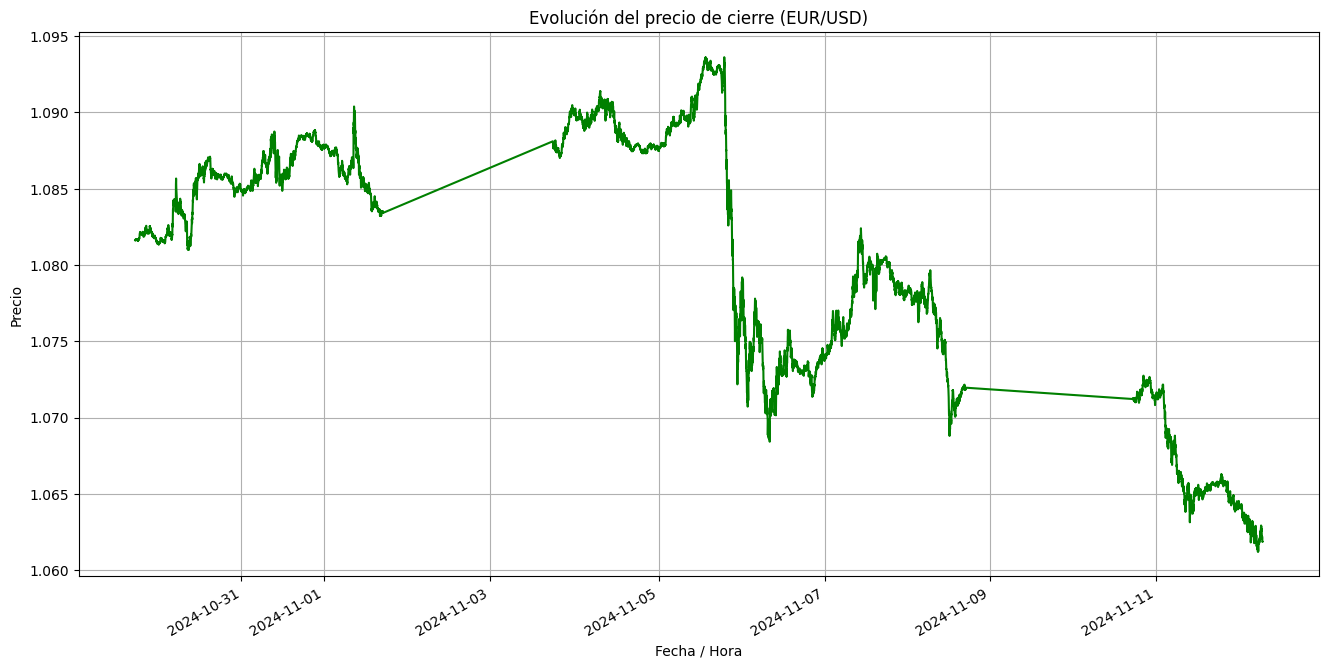

In [21]:
# Crea un gráfico y muesta la evolución del precio de cierre.
df['Close'].plot(grid = True,
                 title ='Evolución del precio de cierre (EUR/USD)',
                 color='green',
                 figsize =(16,8))

# Establece valores para las etiquetas de los ejes X e Y.
plt.xlabel('Fecha / Hora')
plt.ylabel('Precio')

#### 4. Calculamos las dos medias móviles: MMS(50) y MMS(200).

Text(0, 0.5, 'Precio')

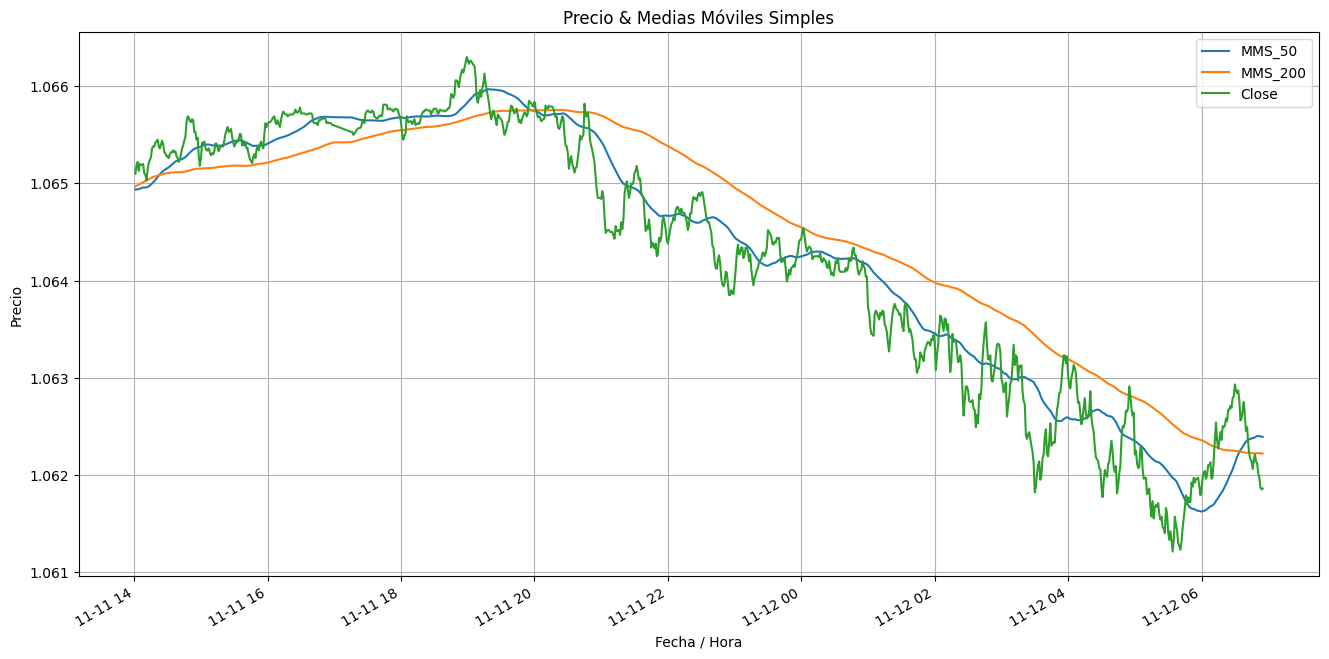

In [22]:
# Calcula la media móvil de 50 periodos
df['MMS_50'] = df.Close.rolling(50).mean()
# Calcula la media móvil de 200 periodos
df['MMS_200'] = df.Close.rolling(200).mean()
# Muestra un gráfico de las dos medias móviles y del precio de cierre.
# Solo muestra las últimas 1000 barras)
df[['MMS_50','MMS_200','Close']][-1000:].plot(grid =True,  
                                              title ='Precio & Medias Móviles Simples',                             
                                              figsize =(16,8))
plt.xlabel('Fecha / Hora')
plt.ylabel('Precio')

#### 5. Generamos las señales de entrada y salida y computamos los retornos de la estrateiga.

In [23]:
# Creamos una columna que muestre la posición de la estrategia.
# Utilizamos la función where() de Numpy para comprobar en cada una de las filas 
# de nuestro dataframe si la columna MMS_50 es mayor que MMS_200. Si la condición
# es cierta la columna Posición valdrá 1, en caso contrario 0.
df['Posicion'] = np.where(df['MMS_50'] > df['MMS_200'], 1, 0)
# Creamos una columna que muestre el retorno de del mercado en puntos.
df['Retorno_Mercado'] = df.Close-df.Close.shift(1) # Resta cierre de cierre anterior.
# Calculamos el retorno de la estrategia
df['Retorno_Estrategia'] = df['Retorno_Mercado'] * df['Posicion'].shift(1)
df.tail()

,Open,High,Low,Close,MMS_50,MMS_200,Posicion,Retorno_Mercado,Retorno_Estrategia
Time,,,,,,,,,
2024-11-12 06:51:00-05:00,1.06201,1.06208,1.06192,1.06202,1.062400,1.062223,1,-0.00010,-0.00010
2024-11-12 06:52:00-05:00,1.06195,1.06200,1.06192,1.06197,1.062399,1.062223,1,-0.00005,-0.00005
2024-11-12 06:53:00-05:00,1.06186,1.06196,1.06180,1.06187,1.062396,1.062222,1,-0.00010,-0.00010
2024-11-12 06:54:00-05:00,1.06183,1.06190,1.06178,1.06185,1.062394,1.062220,1,-0.00002,-0.00002
2024-11-12 06:55:00-05:00,1.06185,1.06190,1.06175,1.06186,1.062391,1.062220,1,0.00001,0.00001


#### 6. Mostramos el Equity Curve de la estrategia versus el Benchmark (EURUSD).

Text(0, 0.5, 'Retorno Acumulado (Puntos)')

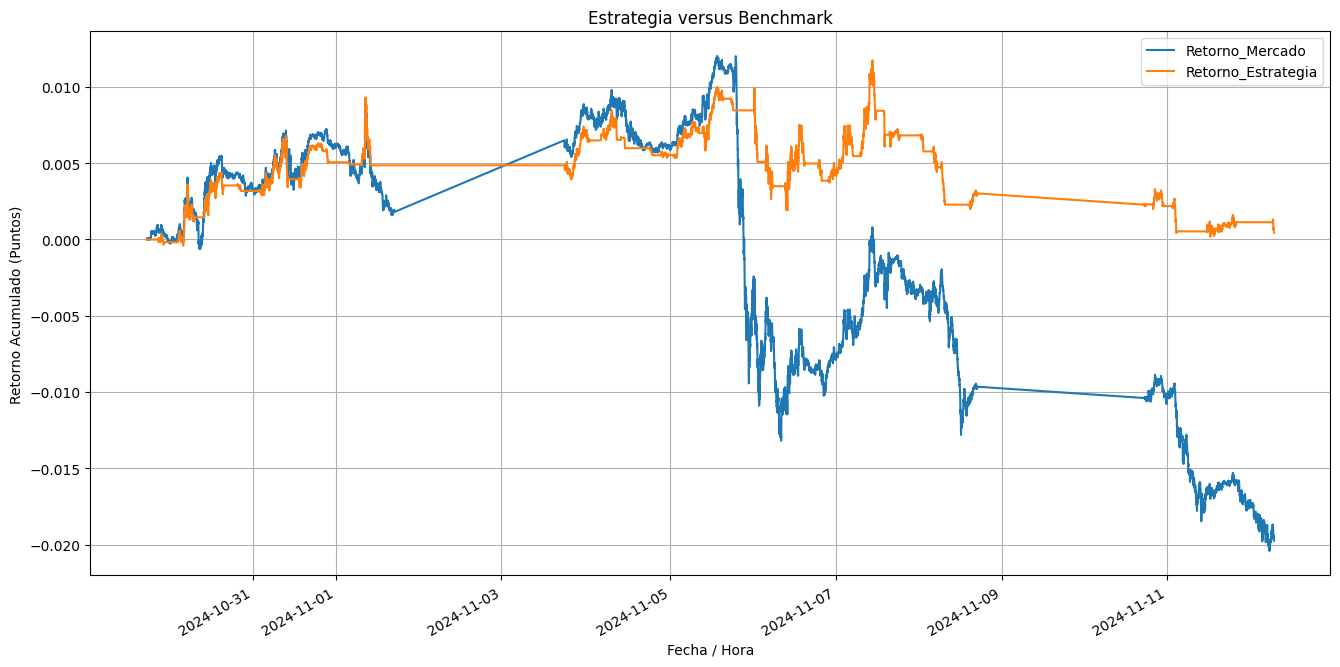

In [24]:
# Mostramos el retorno acumulado de la estrategia y del mercado.
# La función "cumsum()" permite realizar una suma acumulativa de los retornos.
df[['Retorno_Mercado','Retorno_Estrategia']].cumsum().plot(grid = True,
                                                         title ='Estrategia versus Benchmark',
                                                         figsize =(16,8))
plt.xlabel('Fecha / Hora')
plt.ylabel('Retorno Acumulado (Puntos)')

In [25]:
# Desconecta nuestra aplicación de IB. 
ib.disconnect()